### 1. Library Import and Setup
Importing necessary libraries for data manipulation, visualization, and modeling. A helper function is defined to convert text-based duration into total minutes.

In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder

### 2. Data Loading and Feature Engineering
Loading the dataset and processing temporal features (Date of Journey, Dep/Arrival Time). Categorical variables are handled using mapping for ordinal data and One-Hot Encoding for nominal data.

In [204]:
dataset = pd.read_excel('/home/mahmoudahmad/IBM_AI_Engineering/projects/AirLine/Data_Train.xlsx')
dataset.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [205]:
dataset.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [206]:
dataset = dataset.dropna()
dataset.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [207]:
dataset['Date_of_Journey'] = pd.to_datetime(dataset['Date_of_Journey'])
dataset['Journey_Day'] = dataset['Date_of_Journey'].dt.day
dataset['Journey_Month'] = dataset['Date_of_Journey'].dt.month

dataset.drop(['Date_of_Journey'],axis=1,inplace=True)

/tmp/ipykernel_6856/3233049310.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dataset['Date_of_Journey'] = pd.to_datetime(dataset['Date_of_Journey'])


In [208]:
dataset['Dep_Time'] = pd.to_datetime(dataset['Dep_Time'])
dataset['Dep_Time_H'] = dataset['Dep_Time'].dt.hour
dataset['Dep_Time_M'] = dataset['Dep_Time'].dt.minute

dataset.drop(['Dep_Time'],axis=1,inplace=True)

/tmp/ipykernel_6856/2598665693.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset['Dep_Time'] = pd.to_datetime(dataset['Dep_Time'])


In [209]:
stops_dict = {
    "non-stop": 0,
    "1 stop": 1,
    "2 stops": 2,
    "3 stops": 3,
    "4 stops": 4
}
dataset['Total_Stops'] = dataset['Total_Stops'].map(stops_dict)

In [210]:
dataset['Arrival_Time'] = dataset['Arrival_Time'].str.split(' ').str[0]

dataset['Arrival_Time'] = pd.to_datetime(dataset['Arrival_Time'], format='%H:%M')

dataset['Arrival_Hour'] = dataset['Arrival_Time'].dt.hour
dataset['Arrival_Minute'] = dataset['Arrival_Time'].dt.minute

dataset.drop('Arrival_Time', axis=1, inplace=True)

dataset.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Dep_Time_H,Dep_Time_M,Arrival_Hour,Arrival_Minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,0,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1,No info,13302,1,3,16,50,21,35


In [ ]:
def convert_duration(duration):
    h = 0
    m = 0
    parts = duration.split()
    for part in parts:
        if 'h' in part:
            h = int(part.replace('h', ''))
        elif 'm' in part:
            m = int(part.replace('m', ''))
    return h * 60 + m

dataset['Duration_Minutes'] = dataset['Duration'].apply(convert_duration)
dataset.drop('Duration', axis=1, inplace=True)

In [212]:
dataset.drop('Route', axis=1, inplace=True)
dataset.drop('Additional_Info', axis=1, inplace=True)

In [213]:
dataset.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_Day,Journey_Month,Dep_Time_H,Dep_Time_M,Arrival_Hour,Arrival_Minute,Duration_Minutes
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,170
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,445
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,1140
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,325
4,IndiGo,Banglore,New Delhi,1,13302,1,3,16,50,21,35,285


In [214]:
cc = ['Airline', 'Source', 'Destination']
encoder = OneHotEncoder(sparse_output=False,drop='first')
encoded_data = encoder.fit_transform(dataset[cc])
encoded_data_df = pd.DataFrame(encoded_data,columns=encoder.get_feature_names_out(cc),index=dataset.index)
prepped_data = pd.concat([dataset.drop(columns=cc), encoded_data_df], axis=1)

In [215]:
print("Shape after One-Hot:", prepped_data.shape)
prepped_data.head()

Shape after One-Hot: (10682, 29)


,Total_Stops,Price,Journey_Day,Journey_Month,Dep_Time_H,Dep_Time_M,Arrival_Hour,Arrival_Minute,Duration_Minutes,Airline_Air India,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,24,3,22,20,1,10,170,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,7662,1,5,5,50,13,15,445,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,13882,9,6,9,25,4,25,1140,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,6218,12,5,18,5,23,30,325,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,13302,1,3,16,50,21,35,285,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 3. Outlier Removal and Data Splitting
Filtering out extreme price outliers to improve model stability. The target variable is log-transformed to normalize its distribution, followed by scaling the features.

In [216]:
df_clean = prepped_data[prepped_data['Price'] <= 40000].copy()
X = prepped_data.drop(['Price'],axis=1).dropna()
y = prepped_data['Price'].dropna()

In [217]:
y_log = np.log1p(y)
X_train,X_test,y_train_log,y_test_log = train_test_split(X,y_log,random_state=42,test_size=0.2)

In [218]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4. Model Training and Evaluation
Training an XGBoost Regressor with optimized hyperparameters. Predictions are inverse-transformed to calculate R² and RMSE on the original price scale.

Final Model R² Score: 0.8312
Root Mean Squared Error: 1907.60


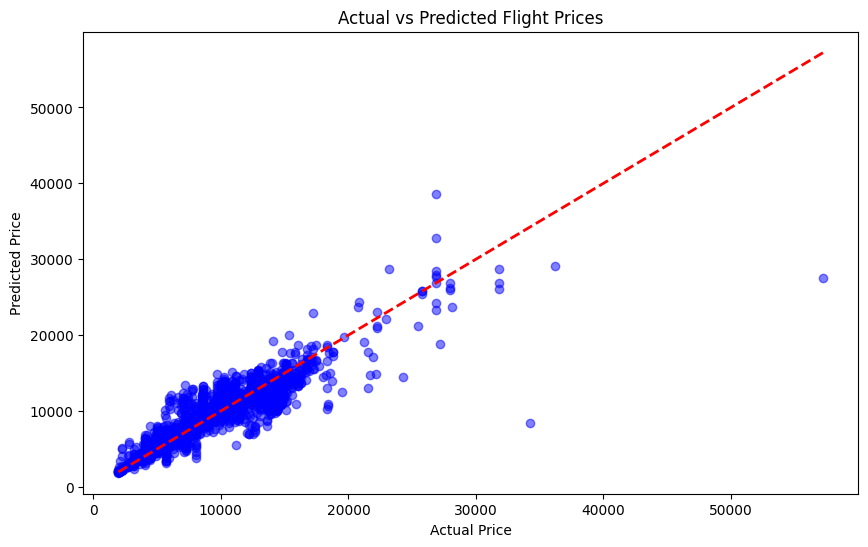

In [219]:
model = XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=7,
    random_state=42, 
    n_jobs=-1
)

model.fit(X_train_scaled, y_train_log)

y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test_log)

r2 = r2_score(y_test_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))

print(f"Final Model R² Score: {r2:.4f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

plt.figure(figsize=(10,6))
plt.scatter(y_test_real, y_pred, alpha=0.5, color='blue')
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Flight Prices")
plt.show()